# 1 - Configuration
*   Installation
*   import libraries
*   Set parameters
*   Import data
*   Define functions
*   Plot data distribution




**Install requirements**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip3 install wandb

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet, resnet18, vgg16

from PIL import Image
from tqdm.notebook import tqdm

from torchvision.datasets import VisionDataset
import os.path
import sys

from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

**Get data from github**

In [0]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, X = None, y = None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)
        
        self.transform = transform
        self.target_transform = target_transform
        self.labels = []
        self.array = []

        if X is not None:
          self.array = np.array(X)
          self.labels = np.array(y)
          return;

        f = open(root + split,"r")
        
        for image in f.read().splitlines():
          if image.split("/")[0] != "BACKGROUND_Google":
            self.array.append(image)
            self.labels.append(self.target_transform.transform([image.split("/")[0]])[0])
        f.close()
        self.labels = np.array(self.labels)
        self.array = np.array(self.array)

    def __getitem__(self, index):
        image = pil_loader("./Homework2-Caltech101/101_ObjectCategories/" + self.array[index])
        label = self.target_transform.transform([self.array[index].split("/")[0]])[0]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
      length = self.array.size
      return length

**Prepare Dataset**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

In [0]:
# Clone github repository with data
if not os.path.isdir('./Homework2-Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git

DATA_DIR = 'Homework2-Caltech101'
sub_folder = DATA_DIR + '/101_ObjectCategories'
classes = [ item for item in os.listdir(sub_folder) if os.path.isdir(os.path.join(sub_folder, item)) and "BACKGROUND" not in item ]
encoder = LabelEncoder()
encoder.fit(classes)

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='/train.txt', transform=train_transform, target_transform=encoder)
test_dataset = Caltech(DATA_DIR, split='/test.txt', transform=eval_transform, target_transform=encoder)

#train_indexes, val_indexes = train_test_split( np.arange(train_dataset.labels.shape[0]), test_size= 0.5, stratify=train_dataset.labels)
test_indexes = test_dataset.labels

#train_dataset = Subset(train_dataset, train_indexes)
#val_dataset = Subset(train_dataset, val_indexes)

X_train, X_val, y_train, y_val = train_test_split(train_dataset.array, train_dataset.labels, test_size=0.5, stratify=train_dataset.labels)
train_dataset = Caltech('./Homework2-Caltech101/', X = X_train, y = y_train,  transform = train_transform, target_transform = encoder)
val_dataset= Caltech('./Homework2-Caltech101/', X = X_val, y = y_val,  transform = train_transform, target_transform = encoder)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Validation Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 13.72 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9149/9149), done.
Train Dataset: 2892
Validation Dataset: 2892
Test Dataset: 2893


In [0]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output.data, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    sm = torch.nn.Softmax()
    return preds, [sm(el)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx].cpu())
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            encoder.classes_[preds[idx]],
            probs[idx] * 100.0,
            encoder.classes_[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [0]:
def train_net(net, comment, NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, show_images=False, net_name = "None", scheduler = "None"):
  net = net.to(DEVICE) 
  cudnn.benchmark 

  current_step = 0
  #best_accuracy = 0
  best_loss = 1000000
  loss_array = np.zeros(NUM_EPOCHS)
  accuracy_array = np.zeros(NUM_EPOCHS)
  tb = SummaryWriter(comment = comment)
  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    for param_group in optimizer.param_groups:
      lr = param_group['lr']
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, lr))
    running_loss = 0.0

    for phase in ['train', 'val']:
      if phase == 'train':
        for images, labels in train_dataloader:
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          if (show_images == True): #tensorboard plot
            if epoch == 0:
              if current_step % 5 == 1:    # every 10 mini-batches...

                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                tb.add_figure('predictions vs. actuals, epoch 0',
                                plot_classes_preds(net, images, labels),
                                global_step=epoch * len(train_dataloader) + current_step)
            if epoch == NUM_EPOCHS-1:
               if current_step % 5 == 1:
                tb.add_figure('predictions vs. actuals, last epoch',
                                plot_classes_preds(net, images, labels),
                                global_step=epoch * len(train_dataloader) + current_step)
          
          tb.flush()
              

          net.train() 

          # PyTorch, by default, accumulates gradients after each backward pass
          # We need to manually set the gradients to zero before starting a new iteration
          optimizer.zero_grad() # Zero-ing the gradients

          # Forward pass to the network
          outputs = net(images)

          # Compute loss based on output and ground truth
          loss = criterion(outputs, labels)

          running_loss += loss.item() * images.size(0)

          # Log loss
          if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))
          # Compute gradients for each layer and update weights
          loss.backward()  # backward pass: computes gradients
          optimizer.step() # update weights based on accumulated gradients
          current_step += 1

        # Step the scheduler
        epoch_loss = running_loss / len(train_dataloader)
        print('Total Loss {}'.format(running_loss))
        if scheduler != "None":
          scheduler.step() 


      else: #validation
        net.train(False)
        running_corrects = 0
        for images, labels in tqdm(val_dataloader):
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          # Forward Pass
          outputs = net(images)
          # Get predictions
          _, preds = torch.max(outputs.data, 1)
          # Update Corrects
          running_corrects += torch.sum(preds == labels.data).data.item()

        # Calculate Accuracy
        accuracy = running_corrects / float(len(val_dataset))
        loss_array[epoch] = running_loss
        accuracy_array[epoch] = accuracy
        print('Validation Accuracy: {}'.format(accuracy))

        #if accuracy > best_accuracy:
        #  best_acccuracy = accuracy
        if epoch_loss < best_loss:
          best_loss = running_loss
          if (net_name != "resnet"):
            best_net = type(net)()
            best_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
            best_net.load_state_dict(net.state_dict()) 

  tb.close()
  if (net_name != "resnet"):
    return best_net, loss_array, accuracy_array
  else:
    return net, loss_array, accuracy_array

In [0]:
def test_net(best_net, test_dataloader, comment=None):
  net = best_net.to(DEVICE) 
  net.train(False) 

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = net(images)
    _, preds = torch.max(outputs.data, 1)
    running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = running_corrects / float(len(test_dataset))

  print('Test Accuracy: {}'.format(accuracy))
  return accuracy

In [0]:
class_numbers = encoder.transform(classes)
labels_joined = [*train_dataset.labels, *val_dataset.labels, *test_dataset.labels]
count_array = []
label_array = []
for i in range(len(encoder.classes_)):
    count = 0
    for j in range(len(labels_joined)):
        if class_numbers[i] == labels_joined[j]:
            count += 1
    count_array.append(count)
    label_array.append(classes[i])
df = pd.DataFrame(list(zip(label_array, count_array)), columns =['Label', 'Count']) 
result = df.sort_values('Count', ascending=False)
result

Label  Count
5      airplanes    800
30    Motorbikes    798
17    Faces_easy    435
58         Faces    435
93         watch    239
..           ...    ...
80      wild_cat     34
16      garfield     34
60     binocular     33
19     metronome     32
35  inline_skate     31

[101 rows x 2 columns]

In [0]:
result.Label.values

array(['airplanes', 'Motorbikes', 'Faces_easy', 'Faces', 'watch',
       'Leopards', 'bonsai', 'car_side', 'ketch', 'chandelier',
       'hawksbill', 'grand_piano', 'brain', 'butterfly', 'helicopter',
       'menorah', 'kangaroo', 'starfish', 'trilobite', 'buddha', 'ewer',
       'sunflower', 'scorpion', 'revolver', 'laptop', 'ibis', 'llama',
       'minaret', 'umbrella', 'electric_guitar', 'crab', 'crayfish',
       'cougar_face', 'dragonfly', 'flamingo', 'ferry', 'dalmatian',
       'lotus', 'dolphin', 'euphonium', 'stop_sign', 'soccer_ball',
       'joshua_tree', 'elephant', 'schooner', 'chair', 'lamp', 'yin_yang',
       'rhino', 'wheelchair', 'stegosaurus', 'cellphone', 'cup',
       'pyramid', 'sea_horse', 'windsor_chair', 'nautilus', 'accordion',
       'hedgehog', 'bass', 'emu', 'pizza', 'dollar_bill',
       'crocodile_head', 'gramophone', 'crocodile', 'camera', 'tick',
       'rooster', 'cougar_body', 'barrel', 'pagoda', 'ceiling_fan',
       'beaver', 'flamingo_head', 'pigeo

In [0]:
result.head(10)

Label  Count
8    airplanes    800
0   Motorbikes    798
78  Faces_easy    435
28       Faces    435
92       watch    239
25    Leopards    200
48      bonsai    128
44    car_side    123
42       ketch    114
20  chandelier    107

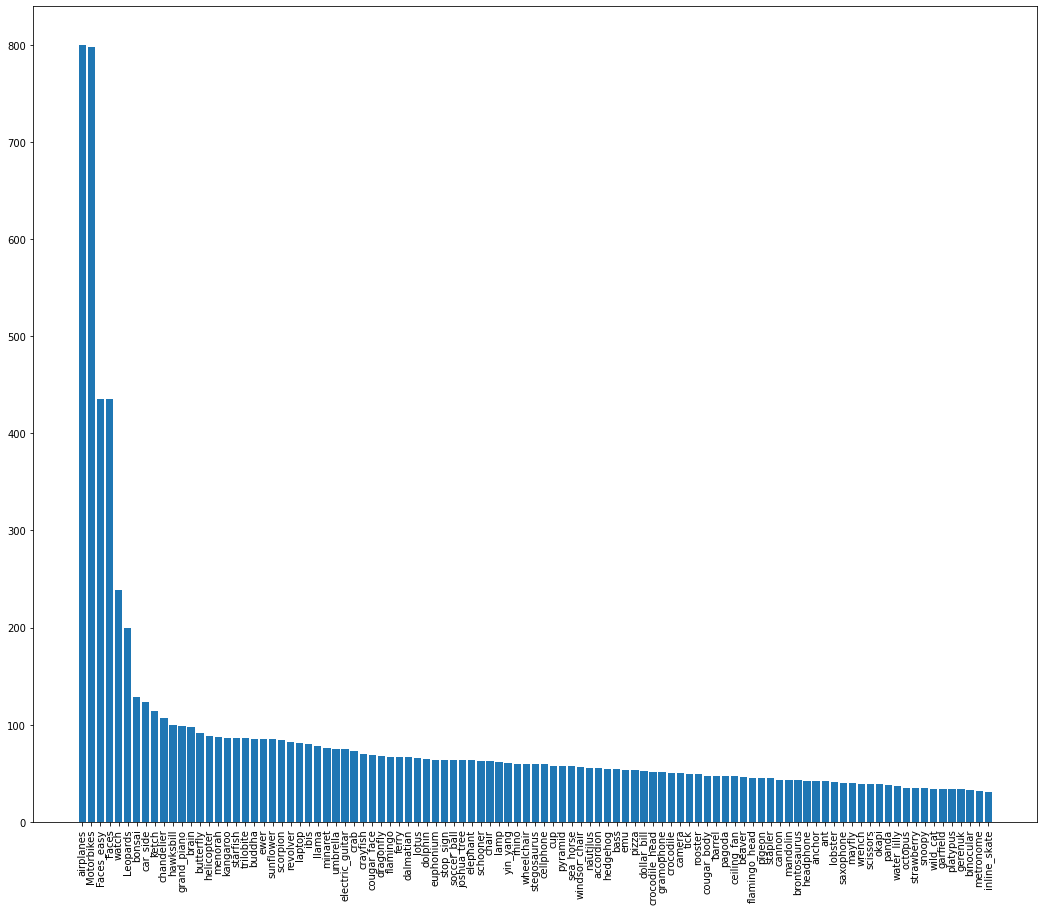

In [0]:
plt.figure(figsize=(18, 15))
plt.bar(result.Label, result.Count)
plt.xticks(rotation='vertical')
plt.show()

# 2 - Training from scratch

In [0]:
LR = 2e-4            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 20     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.5          # Multiplicative factor for learning rate step-down
LOG_FREQUENCY = 10

In [0]:
net = alexnet(pretrained=False) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum

optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_1, total_loss_2_1, accuracy_2_1 = train_net(net, "p2_model1", NUM_EPOCHS, LOG_FREQUENCY,  optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_2_1 = test_net(best_net_1, test_dataloader)

In [0]:
LR = 2e-4            
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20     
STEP_SIZE = 10      
GAMMA = 0.5          
LOG_FREQUENCY = 10

net = alexnet(pretrained=False) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_1, total_loss_2_1_1, accuracy_2_1_1 = train_net(net, "p2_model2", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_2_1_3 = test_net(best_net_1, test_dataloader)

In [0]:
LR = 2e-4            
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20     
STEP_SIZE = 10      
GAMMA = 0.5          
LOG_FREQUENCY = 10

net = alexnet(pretrained=False) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_1, total_loss_2_1_2, accuracy_2_1_2 = train_net(net, "p2_model2", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_2_1_2 = test_net(best_net_1, test_dataloader)

In [0]:
LR = 1e-4           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20     
STEP_SIZE = 5       
GAMMA = 0.5          
LOG_FREQUENCY = 10

net = alexnet(pretrained=False) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_1, total_loss_2_2, accuracy_2_2 = train_net(net, "p2_model2", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_2_2 = test_net(best_net_1, test_dataloader)

In [0]:
LR = 1e-4           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20     
STEP_SIZE = 5       
GAMMA = 0.5          
LOG_FREQUENCY = 10

net = alexnet(pretrained=False) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_1, total_loss_2_2_1, accuracy_2_2_1 = train_net(net, "p2_model2", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_2_2_3 = test_net(best_net_1, test_dataloader)

In [0]:
LR = 1e-4           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20     
STEP_SIZE = 5       
GAMMA = 0.5          
LOG_FREQUENCY = 10

net = alexnet(pretrained=False) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_1, total_loss_2_2_2, accuracy_2_2_2 = train_net(net, "p2_model2", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_2_2_2 = test_net(best_net_1, test_dataloader)

In [0]:
LR = 1e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 25    
STEP_SIZE = 15       
GAMMA = 0.1          
LOG_FREQUENCY = 10

net = alexnet(pretrained=False) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_1, total_loss_2_3, accuracy_2_3 = train_net(net, "p2_model3", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_2_3 = test_net(best_net_1, test_dataloader)

In [0]:
LR = 1e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20     
STEP_SIZE = 8       
GAMMA = 0.25          
LOG_FREQUENCY = 10

net = alexnet(pretrained=False) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_1, total_loss_2_4, accuracy_2_4 = train_net(net, "p2_model3", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_2_4 = test_net(best_net_1, test_dataloader)

In [0]:
LR = 1e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20     
STEP_SIZE = 8       
GAMMA = 0.1          
LOG_FREQUENCY = 10

net = alexnet(pretrained=False) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_1, total_loss_2_5, accuracy_2_5 = train_net(net, "p2_model3", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_2_5 = test_net(best_net_1, test_dataloader)

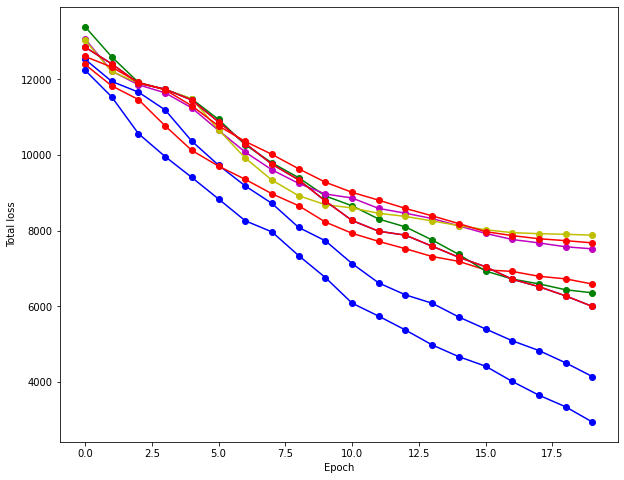

In [0]:
#PLOT TOTAL LOSS
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), total_loss_2_1, '-ob')
plt.plot(np.arange(20), total_loss_2_2, '-or')
plt.plot(np.arange(20), total_loss_2_3[0:20], '-og')
plt.plot(np.arange(20), total_loss_2_4, '-om')
plt.plot(np.arange(20), total_loss_2_5, '-oy')
plt.plot(np.arange(20), total_loss_2_1_1, '-ob')
plt.plot(np.arange(20), total_loss_2_1_2, '-ob')
plt.plot(np.arange(20), total_loss_2_2_1, '-or')
plt.plot(np.arange(20), total_loss_2_1_2, '-or')
plt.xlabel('Epoch')
plt.ylabel('Total loss')
plt.show()

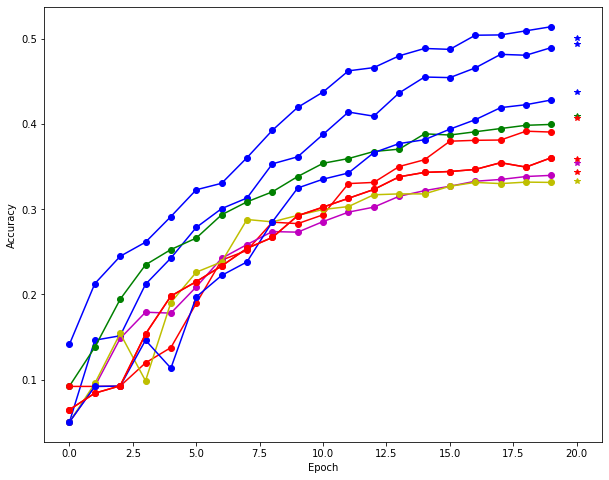

In [0]:
#PLOT ACCURACY
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), accuracy_2_1, '-ob')
plt.plot(20, accuracy_test_2_1, '*b')
plt.plot(np.arange(20), accuracy_2_2, '-og')
plt.plot(20, accuracy_test_2_2, '*g')
plt.plot(np.arange(20), accuracy_2_3[0:20], '-or')
plt.plot(20, accuracy_test_2_3, '*r')
plt.plot(np.arange(20), accuracy_2_4, '-om')
plt.plot(20, accuracy_test_2_4, '*m')
plt.plot(np.arange(20), accuracy_2_5, '-oy')
plt.plot(20, accuracy_test_2_5, '*y')
plt.plot(np.arange(20), accuracy_2_1_1, '-ob')
plt.plot(20, accuracy_test_2_1_3, '*b')
plt.plot(np.arange(20), accuracy_2_1_2, '-ob')
plt.plot(20, accuracy_test_2_1_2, '*b')
plt.plot(np.arange(20), accuracy_2_2_1, '-or')
plt.plot(20, accuracy_test_2_2_3, '*r')
plt.plot(np.arange(20), accuracy_2_2_1, '-or')
plt.plot(20, accuracy_test_2_2_2, '*r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 3.1 - Transfer Learning
A.   Load pretrainet alexnet (pretrained=True) \\
B.   Change normalize function of data preprocessing

In [0]:
train_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), 
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )])
eval_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )])

train_dataset = Caltech(DATA_DIR, split='/train.txt', transform=train_transform, target_transform=encoder)
test_dataset = Caltech(DATA_DIR, split='/test.txt', transform=eval_transform, target_transform=encoder)

test_indexes = test_dataset.labels

X_train, X_val, y_train, y_val = train_test_split(train_dataset.array, train_dataset.labels, test_size=0.5, stratify=train_dataset.labels)
train_dataset = Caltech('./Homework2-Caltech101/', X = X_train, y = y_train,  transform = train_transform, target_transform = encoder)
val_dataset= Caltech('./Homework2-Caltech101/', X = X_val, y = y_val,  transform = train_transform, target_transform = encoder)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [0]:
LR = 1e-5          
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 30     
STEP_SIZE = 15    
GAMMA = 0.25          
LOG_FREQUENCY = 10

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_3, total_loss_3_1_1, accuracy_3_1_1 = train_net(net, "p3_1_model1", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_3_1_1 = test_net(best_net_3, test_dataloader)

In [0]:
LR = 1e-5          
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 30     
STEP_SIZE = 15    
GAMMA = 0.25          
LOG_FREQUENCY = 10

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_3, total_loss_3_1_1a, accuracy_3_1_1a = train_net(net, "p3_1_model1", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_3_1_1a = test_net(best_net_3, test_dataloader)

In [0]:
LR = 1e-5          
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 30     
STEP_SIZE = 15    
GAMMA = 0.25          
LOG_FREQUENCY = 10

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_3, total_loss_3_1_1b, accuracy_3_1_1b = train_net(net, "p3_1_model1", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_3_1_1b = test_net(best_net_3, test_dataloader)

In [0]:
LR = 1e-4          
MOMENTUM = 0.9       
WEIGHT_DECAY = 1e-6  
NUM_EPOCHS = 25     
STEP_SIZE = 20       
GAMMA = 0.1          
LOG_FREQUENCY = 10

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
best_net_3, total_loss_3_1_2, accuracy_3_1_2 = train_net(net, "p3_1_model2", NUM_EPOCHS, LOG_FREQUENCY, optimizer,criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_3_1_2 = test_net(best_net_3, test_dataloader)

In [0]:
LR = 1e-4          
MOMENTUM = 0.9       
WEIGHT_DECAY = 1e-6  
NUM_EPOCHS = 25     
STEP_SIZE = 20       
GAMMA = 0.1          
LOG_FREQUENCY = 10

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
best_net_3, total_loss_3_1_2a, accuracy_3_1_2a = train_net(net, "p3_1_model2", NUM_EPOCHS, LOG_FREQUENCY, optimizer,criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_3_1_2a = test_net(best_net_3, test_dataloader)

In [0]:
LR = 1e-4          
MOMENTUM = 0.9       
WEIGHT_DECAY = 1e-6  
NUM_EPOCHS = 25     
STEP_SIZE = 20       
GAMMA = 0.1          
LOG_FREQUENCY = 10

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
best_net_3, total_loss_3_1_2b, accuracy_3_1_2b = train_net(net, "p3_1_model2", NUM_EPOCHS, LOG_FREQUENCY, optimizer,criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_3_1_2b = test_net(best_net_3, test_dataloader)

In [0]:
LR = 1e-5          
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 30     
STEP_SIZE = 25      
GAMMA = 0.5        
LOG_FREQUENCY = 10

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_3, total_loss_3_1_3, accuracy_3_1_3 = train_net(net, "p3_1_model3", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_3_1_3 = test_net(best_net_3, test_dataloader)

In [0]:
LR = 1e-5          
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 30     
STEP_SIZE = 25      
GAMMA = 0.5        
LOG_FREQUENCY = 10

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_3, total_loss_3_1_3a, accuracy_3_1_3a = train_net(net, "p3_1_model3", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_3_1_3a = test_net(best_net_3, test_dataloader)

In [0]:
LR = 1e-5          
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 30     
STEP_SIZE = 25      
GAMMA = 0.5        
LOG_FREQUENCY = 10

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_3, total_loss_3_1_3b, accuracy_3_1_3b = train_net(net, "p3_1_model3", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_3_1_3b = test_net(best_net_3, test_dataloader)

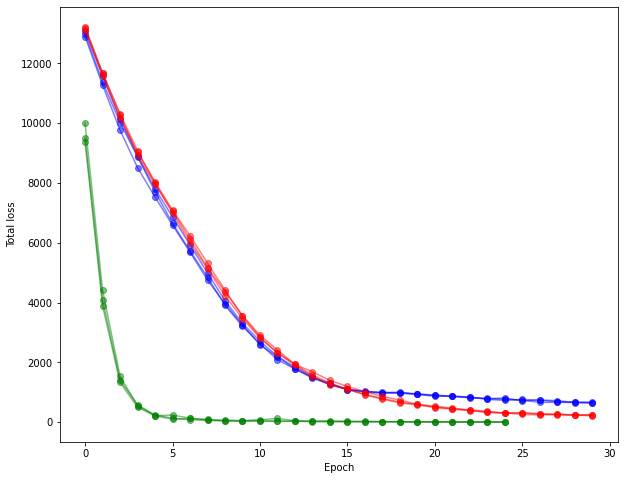

In [0]:
#PLOT TOTAL LOSS
plt.figure(figsize=(10, 8))
plt.plot(np.arange(30), total_loss_3_1_1, '-ob', alpha=0.5)
plt.plot(np.arange(30), total_loss_3_1_1a, '-ob', alpha=0.5)
plt.plot(np.arange(30), total_loss_3_1_1b, '-ob', alpha=0.5)
plt.plot(np.arange(25), total_loss_3_1_2, '-og', alpha=0.5)
plt.plot(np.arange(25), total_loss_3_1_2a, '-og', alpha=0.5)
plt.plot(np.arange(25), total_loss_3_1_2b, '-og', alpha=0.5)
plt.plot(np.arange(30), total_loss_3_1_3, '-or', alpha=0.5)
plt.plot(np.arange(30), total_loss_3_1_3a, '-or', alpha=0.5)
plt.plot(np.arange(30), total_loss_3_1_3b, '-or', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Total loss')
plt.show()

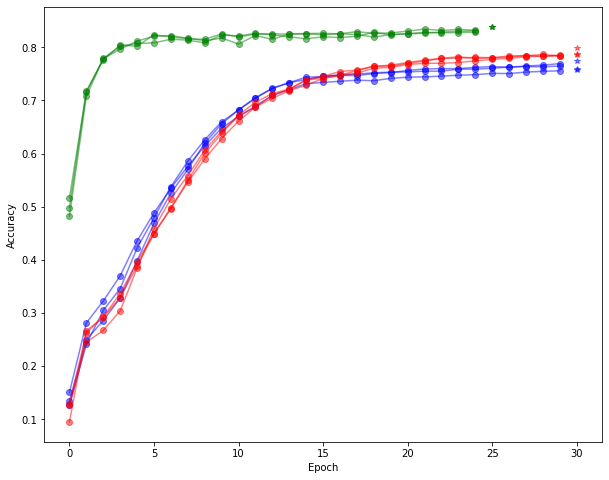

In [0]:
#PLOT ACCURACY
plt.figure(figsize=(10, 8))
plt.plot(np.arange(30), accuracy_3_1_1, '-ob', alpha=0.5)
plt.plot(30, accuracy_test_3_1_1, '*b', alpha=0.5)
plt.plot(np.arange(30), accuracy_3_1_1a, '-ob', alpha=0.5)
plt.plot(30, accuracy_test_3_1_1a, '*b', alpha=0.5)
plt.plot(np.arange(30), accuracy_3_1_1b, '-ob', alpha=0.5)
plt.plot(30, accuracy_test_3_1_1b, '*b', alpha=0.5)

plt.plot(np.arange(25), accuracy_3_1_2, '-og', alpha=0.5)
plt.plot(25, accuracy_test_3_1_2, '*g', alpha=0.5)
plt.plot(np.arange(25), accuracy_3_1_2a, '-og', alpha=0.5)
plt.plot(25, accuracy_test_3_1_2a, '*g', alpha=0.5)
plt.plot(np.arange(25), accuracy_3_1_2b, '-og', alpha=0.5)
plt.plot(25, accuracy_test_3_1_2b, '*g', alpha=0.5)

plt.plot(np.arange(30), accuracy_3_1_3, '-or', alpha=0.5)
plt.plot(30, accuracy_test_3_1_3, '*r', alpha=0.5)
plt.plot(np.arange(30), accuracy_3_1_3a, '-or', alpha=0.5)
plt.plot(30, accuracy_test_3_1_3a, '*r', alpha=0.5)
plt.plot(np.arange(30), accuracy_3_1_3b, '-or', alpha=0.5)
plt.plot(30, accuracy_test_3_1_3b, '*r', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 3.2 - Transfer learning
D. Train only the fully connected layers \\
E. Train only the convolutional layers

In [0]:
LR = 1e-4          
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20     
STEP_SIZE = 25       
GAMMA = 0.5          
LOG_FREQUENCY = 10

net = alexnet(pretrained=True) 
#freeze all the layers
for param in net.parameters():
    param.requires_grad = False

# unfreeze only the fully connected layers
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
for val in net.classifier:
  val.requires_grad = True
  
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
best_net_3_2_1, total_loss_3_2_1, accuracy_3_2_1 = train_net(net, "p32_model1", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_3_2_1 = test_net(best_net_3_2_1, test_dataloader)

In [0]:
LR = 1e-4          
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20     
STEP_SIZE = 25       
GAMMA = 0.5       
LOG_FREQUENCY = 10

net = alexnet(pretrained=True) 
#freeze all the layers
for param in net.parameters():
    param.requires_grad = False

# unfreeze only the convolutional layers
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
for val in net.features:
  val.requires_grad = True


criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_3_2_2, total_loss_3_2_2, accuracy_3_2_2 = train_net(net, "p32_model2", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "alexnet", scheduler)
accuracy_test_3_2_2 = test_net(best_net_3_2_2, test_dataloader)

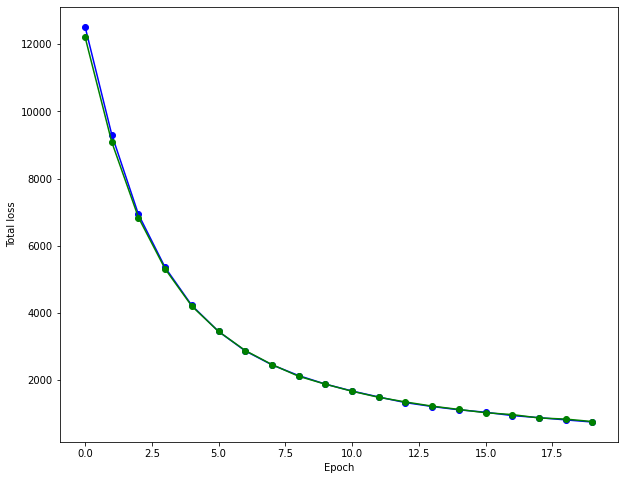

In [0]:
#PLOT TOTAL LOSS
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), total_loss_3_2_1, '-ob')
plt.plot(np.arange(20), total_loss_3_2_2, '-og')
plt.xlabel('Epoch')
plt.ylabel('Total loss')
plt.show()

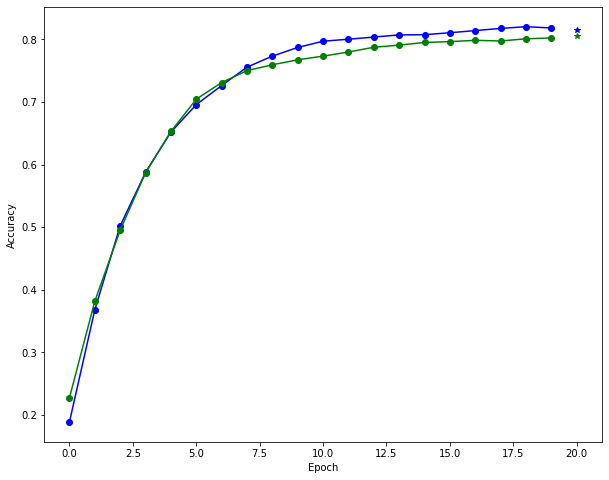

In [0]:
#PLOT ACCURACY
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), accuracy_3_2_1, '-ob')
plt.plot(20, accuracy_test_3_2_1, '*b')
plt.plot(np.arange(20), accuracy_3_2_2, '-og')
plt.plot(20, accuracy_test_3_2_2, '*g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [0]:
basic_net = alexnet(pretrained=True)
print(basic_net.features)
print(basic_net.classifier)

# 4 - Data augmentation
*   Add more transforms to the original data


In [0]:
train_transform = transforms.Compose([ transforms.Resize(256),  transforms.RandomRotation(degrees=10),
                                      transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), 
                                    transforms.CenterCrop(224),
                                      transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )])
test_transform = transforms.Compose([ transforms.Resize(256), 
                                      transforms.CenterCrop(224),
                                     transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )])

train_dataset = Caltech(DATA_DIR, split='/train.txt', transform=train_transform, target_transform=encoder)
test_dataset = Caltech(DATA_DIR, split='/test.txt', transform=test_transform, target_transform=encoder)

test_indexes = test_dataset.labels

X_train, X_val, y_train, y_val = train_test_split(train_dataset.array, train_dataset.labels, test_size=0.5, stratify=train_dataset.labels)
train_dataset = Caltech('./Homework2-Caltech101/', X = X_train, y = y_train,  transform = train_transform, target_transform = encoder)
val_dataset= Caltech('./Homework2-Caltech101/', X = X_val, y = y_val,  transform = train_transform, target_transform = encoder)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1809.5, 7233.5, -0.5)

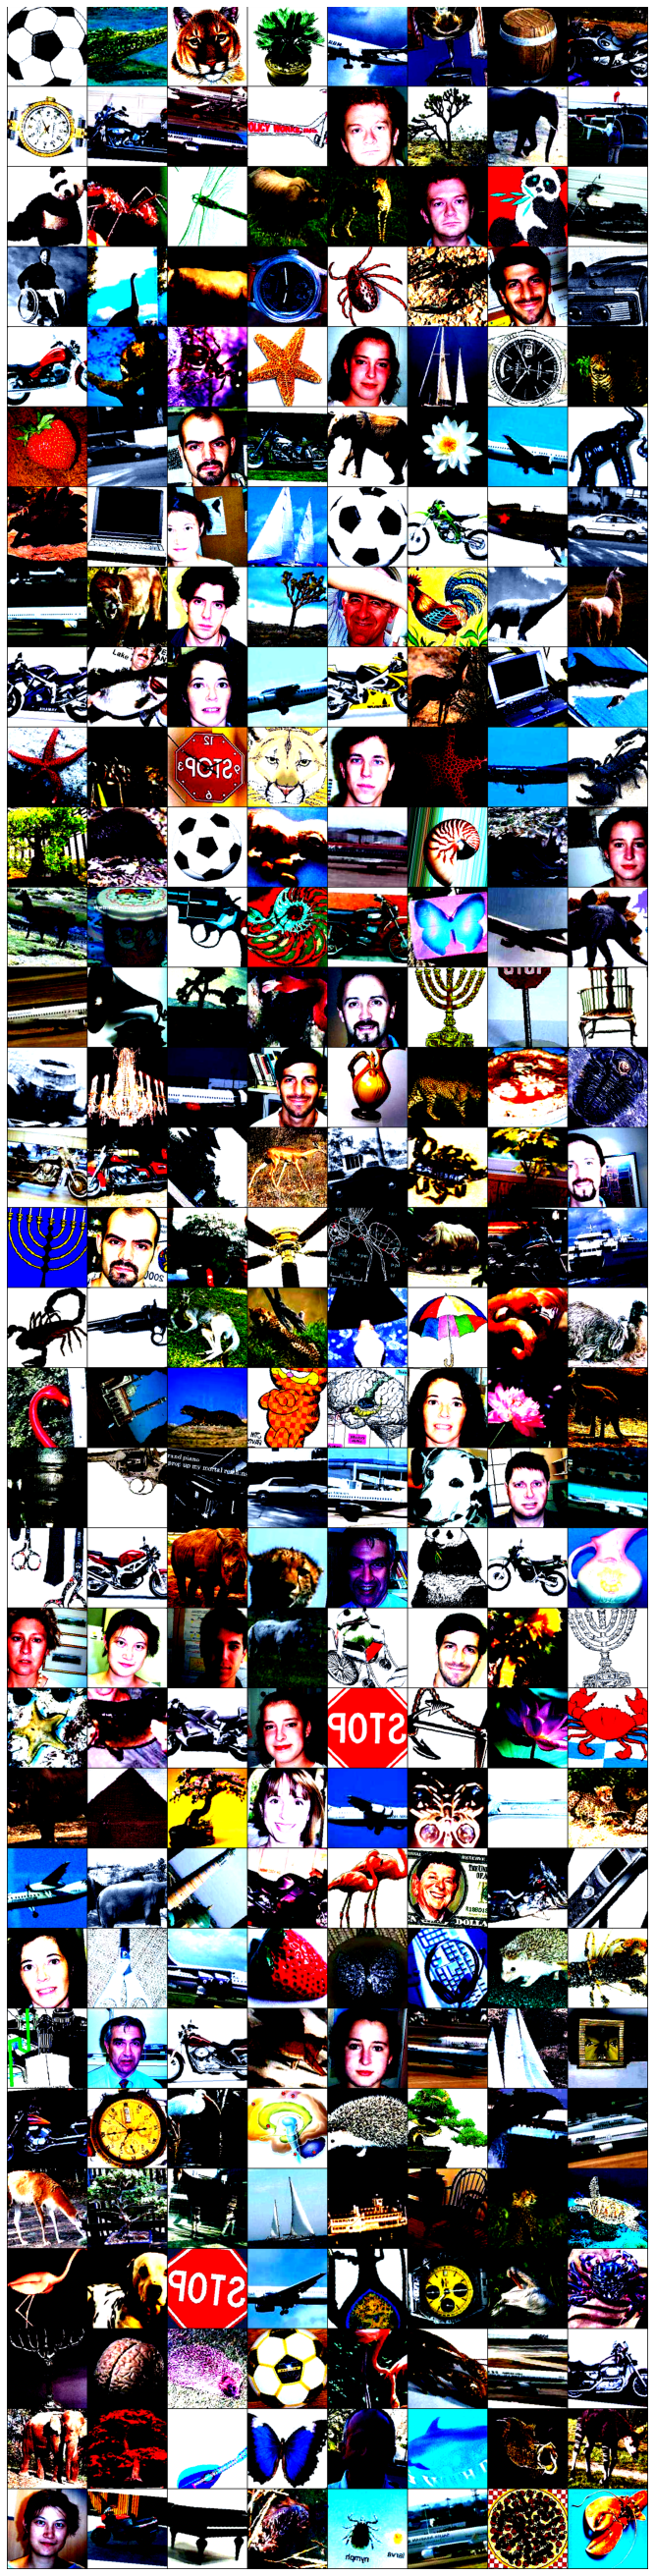

In [0]:
train_iter = iter(train_dataloader)
images, labels = train_iter.next()
grid = torchvision.utils.make_grid(images)
plt.figure(figsize=(12, 48))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1809.5, 7233.5, -0.5)

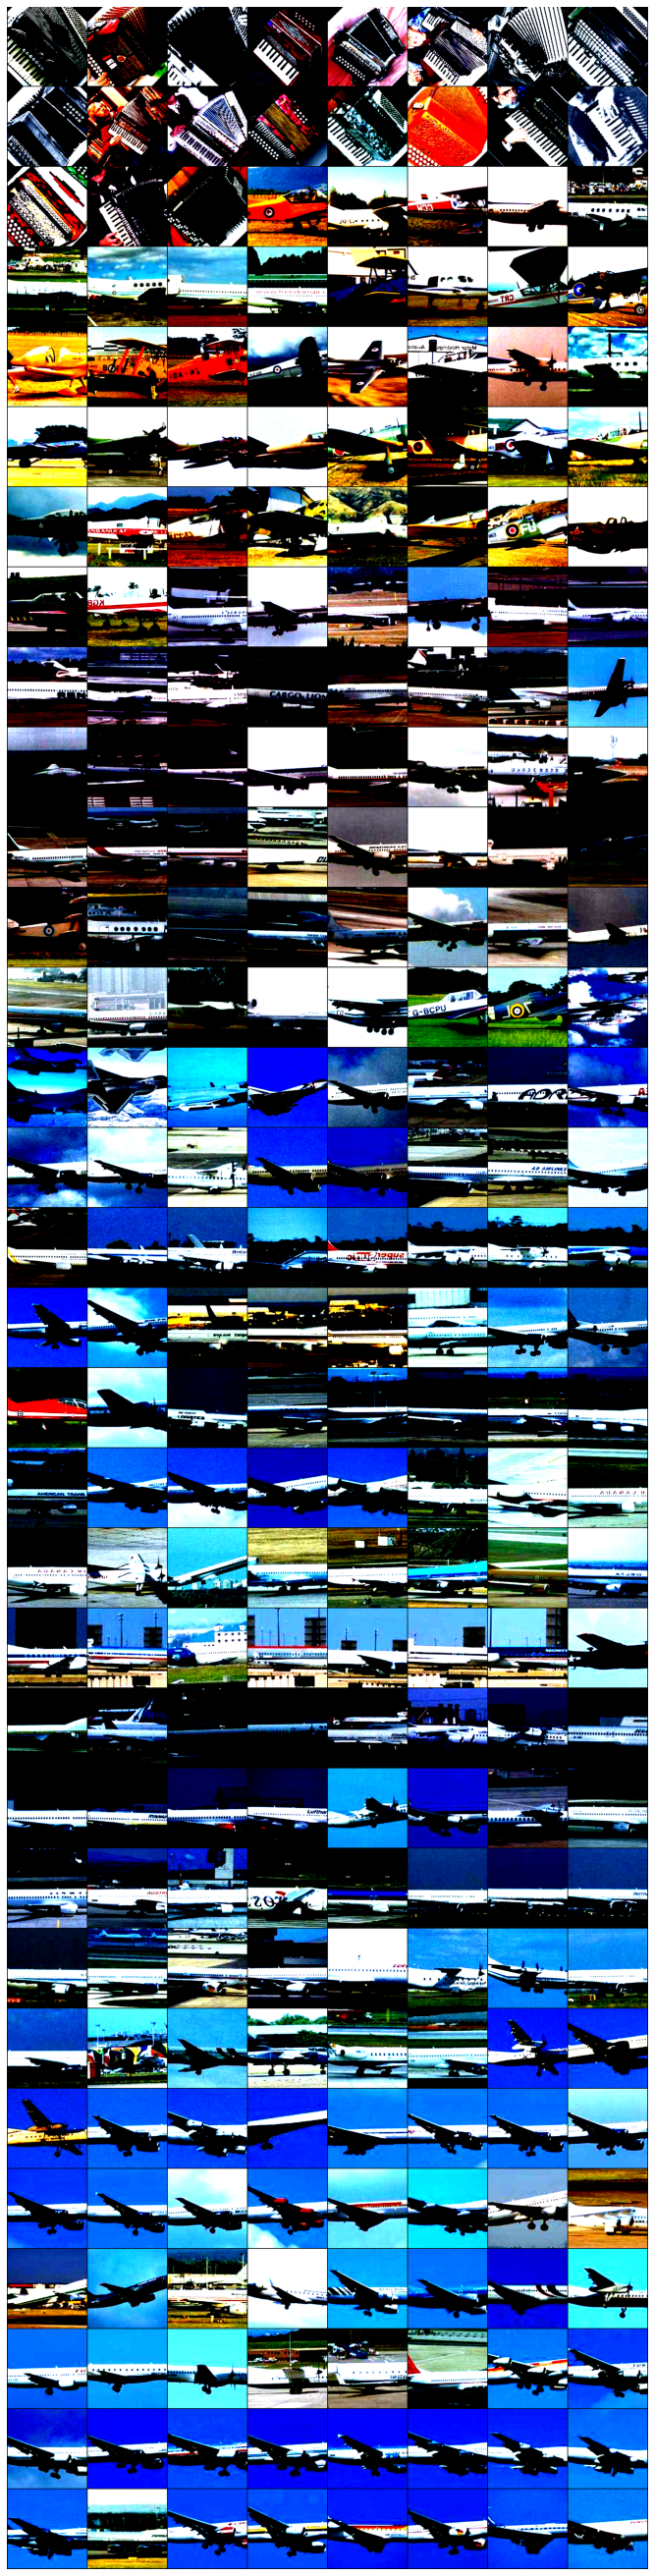

In [0]:
test_iter = iter(test_dataloader)
images, labels = test_iter.next()
grid = torchvision.utils.make_grid(images)
plt.figure(figsize=(12, 48))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')

In [0]:
NUM_EPOCHS = 20     
GAMMA = 0.1          
LOG_FREQUENCY = 10
LR = 1e-4

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = LR)

best_net_f_1, total_loss_f_1, accuracy_f_1 = train_net(net, "alexnet_f1", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False)
accuracy_test_f_1 = test_net(best_net_f_1, test_dataloader)

In [0]:
train_transform = transforms.Compose([ transforms.Resize(256), transforms.RandomRotation(degrees=10),
                                      transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7), 
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )])
test_transform = transforms.Compose([ transforms.Resize(256), 
                                      transforms.CenterCrop(224),
                                     transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )])

train_dataset = Caltech(DATA_DIR, split='/train.txt', transform=train_transform, target_transform=encoder)
test_dataset = Caltech(DATA_DIR, split='/test.txt', transform=test_transform, target_transform=encoder)

test_indexes = test_dataset.labels

X_train, X_val, y_train, y_val = train_test_split(train_dataset.array, train_dataset.labels, test_size=0.5, stratify=train_dataset.labels)
train_dataset = Caltech('./Homework2-Caltech101/', X = X_train, y = y_train,  transform = train_transform, target_transform = encoder)
val_dataset= Caltech('./Homework2-Caltech101/', X = X_val, y = y_val,  transform = train_transform, target_transform = encoder)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [0]:
train_iter = iter(train_dataloader)
images, labels = train_iter.next()
grid = torchvision.utils.make_grid(images)
plt.figure(figsize=(12, 48))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')

In [0]:
NUM_EPOCHS = 20     
GAMMA = 0.1          
LOG_FREQUENCY = 10
LR = 1e-4

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = LR)

best_net_f_2, total_loss_f_2, accuracy_f_2 = train_net(net, "alexnet_f1", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False)
accuracy_test_f_2 = test_net(best_net_f_2, test_dataloader)

In [0]:
train_transform = transforms.Compose([ transforms.Resize(256),  
                                      transforms.Grayscale(num_output_channels=3),
                                    transforms.CenterCrop(224),
                                      transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )])
test_transform = transforms.Compose([ transforms.Resize(256), 
                                      transforms.CenterCrop(224),
                                     transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )])

train_dataset = Caltech(DATA_DIR, split='/train.txt', transform=train_transform, target_transform=encoder)
test_dataset = Caltech(DATA_DIR, split='/test.txt', transform=test_transform, target_transform=encoder)

test_indexes = test_dataset.labels

X_train, X_val, y_train, y_val = train_test_split(train_dataset.array, train_dataset.labels, test_size=0.5, stratify=train_dataset.labels)
train_dataset = Caltech('./Homework2-Caltech101/', X = X_train, y = y_train,  transform = train_transform, target_transform = encoder)
val_dataset= Caltech('./Homework2-Caltech101/', X = X_val, y = y_val,  transform = train_transform, target_transform = encoder)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [0]:
train_iter = iter(train_dataloader)
images, labels = train_iter.next()
grid = torchvision.utils.make_grid(images)
plt.figure(figsize=(12, 48))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')

In [0]:
NUM_EPOCHS = 20     
GAMMA = 0.1          
LOG_FREQUENCY = 10
LR = 1e-4

net = alexnet(pretrained=True) 
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = LR)

best_net_f_3, total_loss_f_3, accuracy_f_3 = train_net(net, "alexnet_f1", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False)
accuracy_test_f_3 = test_net(best_net_f_3, test_dataloader)

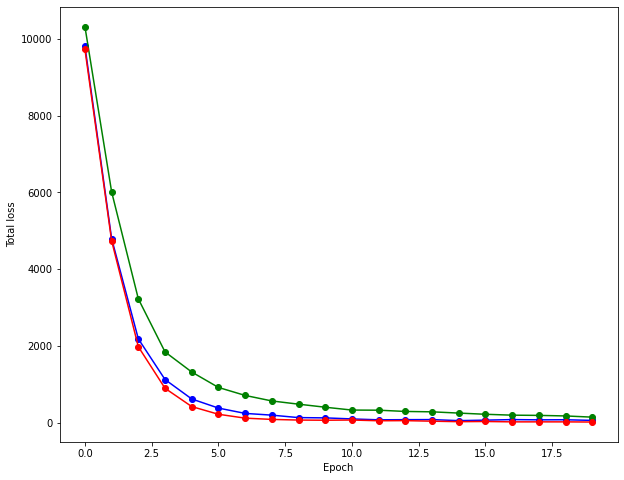

In [0]:
#PLOT TOTAL LOSS
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), total_loss_f_1, '-ob')
plt.plot(np.arange(20), total_loss_f_2, '-og')
plt.plot(np.arange(20), total_loss_f_3, '-or')
plt.xlabel('Epoch')
plt.ylabel('Total loss')
plt.show()

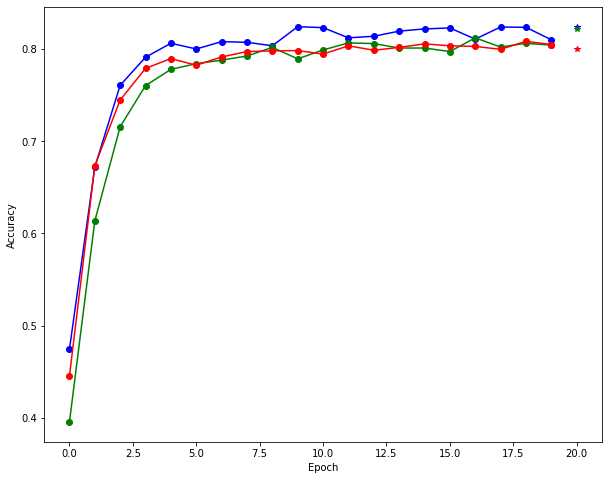

In [0]:
#PLOT ACCURACY
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), accuracy_f_1, '-ob')
plt.plot(20, accuracy_test_f_1, '*b')
plt.plot(np.arange(20), accuracy_f_2, '-og')
plt.plot(20, accuracy_test_f_2, '*g')
plt.plot(np.arange(20), accuracy_f_3, '-or')
plt.plot(20, accuracy_test_f_3, '*r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 5 - Beyond AlexNet
*   Train a different model, I choose to train ResNet18 and vgg16


In [0]:
BATCH_SIZE = 24
train_transform = transforms.Compose([ transforms.Resize(256),  transforms.RandomRotation(degrees=10),
                                      transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(), transforms.CenterCrop(224),
                                      transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )])
eval_transform = transforms.Compose([ transforms.Resize(256), 
                                      transforms.CenterCrop(224),
                                     transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )])

train_dataset = Caltech(DATA_DIR, split='/train.txt', transform=train_transform, target_transform=encoder)
test_dataset = Caltech(DATA_DIR, split='/test.txt', transform=eval_transform, target_transform=encoder)

test_indexes = test_dataset.labels

X_train, X_val, y_train, y_val = train_test_split(train_dataset.array, train_dataset.labels, test_size=0.5, stratify=train_dataset.labels)
train_dataset = Caltech('./Homework2-Caltech101/', X = X_train, y = y_train,  transform = train_transform, target_transform = encoder)
val_dataset= Caltech('./Homework2-Caltech101/', X = X_val, y = y_val,  transform = train_transform, target_transform = encoder)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [0]:
LOG_FREQUENCY = 10
NUM_EPOCHS = 15  
STEP_SIZE = 7
LR = 1e-4
GAMMA = 0.1
net = resnet18(pretrained=True) 

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, NUM_CLASSES)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr = LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_5_1, total_loss_5_1, accuracy_5_1 = train_net(net, "resnet18_1", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "resnet", scheduler)
accuracy_test_5_1 = test_net(best_net_5_1, test_dataloader)

In [0]:
BATCH_SIZE = 56
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
LOG_FREQUENCY = 10
NUM_EPOCHS = 15  
LR = 1e-4
STEP_SIZE = 7
GAMMA = 0.1

net = vgg16(pretrained=True) 
for param in net.parameters():
    param.requires_grad = False

# unfreeze only the FC layers
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
for val in net.classifier:
  val.requires_grad = True
#prima feceva 0.89
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr = LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net_5_2, total_loss_5_2, accuracy_5_2 = train_net(net, "resnet", NUM_EPOCHS, LOG_FREQUENCY, optimizer, criterion, train_dataloader, val_dataloader, False, "resnet", scheduler)
accuracy_test_5_2 = test_net(best_net_5_2, test_dataloader)

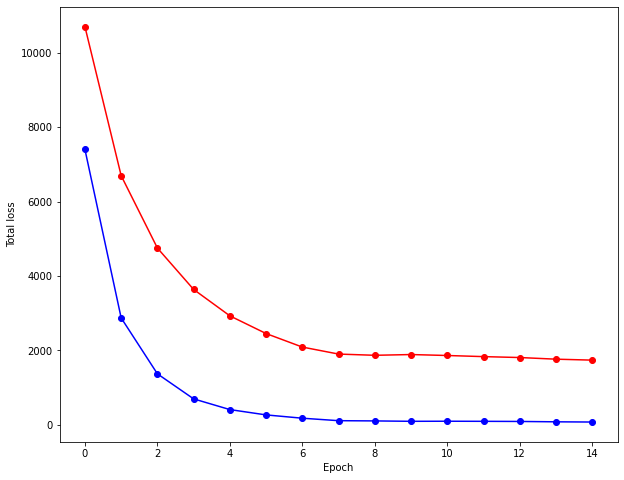

In [0]:
#PLOT TOTAL LOSS
plt.figure(figsize=(10, 8))
plt.plot(np.arange(15), total_loss_5_1, '-ob')
plt.plot(np.arange(15), total_loss_5_2, '-or')
plt.xlabel('Epoch')
plt.ylabel('Total loss')
plt.show()

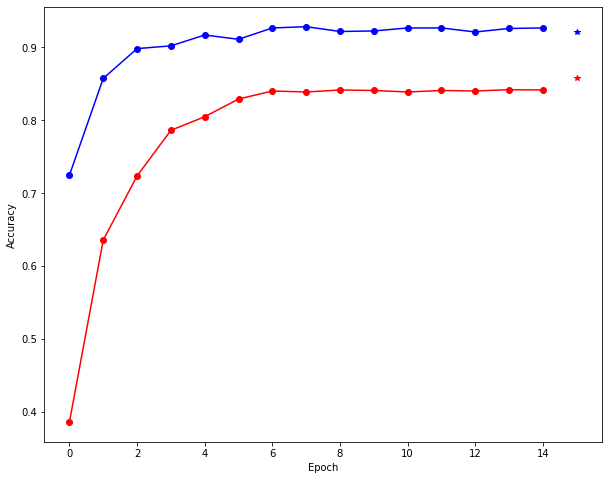

In [0]:
#PLOT ACCURACY
plt.figure(figsize=(10, 8))
plt.plot(np.arange(15), accuracy_5_1, '-ob')
plt.plot(15, accuracy_test_5_1, '*b')
plt.plot(np.arange(15), accuracy_5_2, '-or')
plt.plot(15, accuracy_test_5_2, '*r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()